### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2024 Semester 2

## Assignment 2

**Student Name:**    `Xin Hong`

**Student ID:**     `1351293`

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Sep  8 09:58:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   44C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 56.9 gigabytes of available RAM

You are using a high-RAM runtime!


## This iPython notebook is a template which you should use for your Assignment 2 submission. This file should be submitted at the **Assignment 2: Code** link on the LMS.

In addition to this file, you should submit a written report explaining your results at the **Assignment 2: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

## 1. CNN training

The following code provides a baseline implementation that you will modify by placing code in the speficied sections below. You may also change the batch sizes or image sizes if you wish.

The first block of code loads all the pieces of TensorFlow and Keras we need.  Add more imports here if you need them.


In [4]:
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

print("TensorFlow version: ", tf.__version__)
print("Keras version: ", keras.__version__)

TensorFlow version:  2.17.0
Keras version:  3.4.1


In [5]:
from tensorflow.keras import layers

This block sets the size of the patch that we're going to process with our network.  The patches on disk in the dataset are 64x64 with each image being a pair of patches side by side, so the input images are 128x64. If you change the imsize, the dataloader will rescale the images for you.

In [6]:
# set the image size that we're loading # 64 is the size of the image patches on disk.
imsize = 64

This block loads the training and test datasets. If the 'train' and 'validate' directories are in your current workign directory, the below code will load them. Change the 'directory' arguments if you have put them somewhere else

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [66]:
# If your zip file is in the current directory
# !unzip /content/drive/MyDrive/CV/Ass2/TrainValidation.zip -d /content/drive/MyDrive/CV/Ass2/TrainValidation

In [8]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Ass2/TrainValidation/train/',
    labels='inferred',
    shuffle=True,
    label_mode='int',
    image_size=(2*imsize,imsize))
validation_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Ass2/TrainValidation/validate/',
    labels='inferred',
    label_mode='int',
    image_size=(2*imsize,imsize))

Found 20000 files belonging to 2 classes.
Found 2500 files belonging to 2 classes.


This block extracts 8 examples from the dataset and displays them and their labels

tf.Tensor([0 1 1 1 1 0 1 1], shape=(8,), dtype=int32)


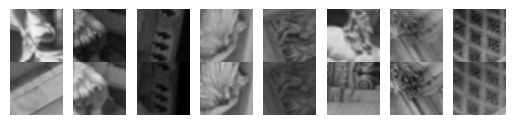

In [8]:
# 1 good; 0 bad
images, labels = train_ds.batch(8).take(1).get_single_element()
images = images[0]
labels = labels[0]
print(labels[0:8])
f, axarr = plt.subplots(1,8)
for i in range(8):
    axarr[i].imshow(images[i,:,:,:].numpy().astype("uint8"))
    axarr[i].set_axis_off()

In [9]:
import random
random.seed(96)
np.random.seed(96)
tf.random.set_seed(96)

### Baseline model implementation

This is the basic model to run for part 1 of the assignment before you make your own models

In [ ]:
mlp1 = keras.Sequential(
    [
        layers.Input((2*imsize,imsize,3)),            # Tell Keras the shape of the input array (a 3-channel twice imsize by imsize image)
        layers.Reshape((2,imsize,imsize,3)),          # Turn the input into two 64x64 images
        layers.LayerNormalization(axis=[-1,-2,-3]),   # Normalize each image independently to mean=zero and sigma=one. YOUR MODEL WILL NOT WORK PROPERLY IF YOU DO NOT DO THIS
        layers.Flatten(),                             # Unravel/flatten the input array
        layers.Dense(16,activation='relu'),           # A single hidden layer with 16 outputs
        layers.Dense(2,activation='softmax')          # A fully-connected layer with a softmax activation function to generate probabilities for the two classes (0bad and 1good)
    ]
)

In [ ]:
# Configure the model
mlp1.compile(optimizer='adam',
           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #use SparseCategoricalCrossentropy because labels are integers. If the labels are one-hot representation, please use CategoricalCrossentropy loss.
           metrics=['accuracy'])

In [ ]:
# Start training
history_mlp = mlp1.fit(train_ds, epochs=20, batch_size=100, validation_data= validation_ds)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 98s 157ms/step - accuracy: 0.9756 - loss: 0.0664 - val_accuracy: 0.9236 - val_loss: 0.2755
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 140s 154ms/step - accuracy: 0.9773 - loss: 0.0640 - val_accuracy: 0.9188 - val_loss: 0.3209
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 153ms/step - accuracy: 0.9777 - loss: 0.0613 - val_accuracy: 0.9168 - val_loss: 0.3287
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 155ms/step - accuracy: 0.9791 - loss: 0.0590 - val_accuracy: 0.9192 - val_loss: 0.3442
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 158ms/step - accuracy: 0.9811 - loss: 0.0511 - val_accuracy: 0.9096 - val_loss: 0.3923
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 150s 172ms/step - accuracy: 0.9815 - loss: 0.0517 - val_accuracy: 0.8916 - val_loss: 0.5361
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 132s 156ms/step - accuracy: 0.9834 - loss: 0.0465 - val_accuracy: 0.9272 - val_loss: 0.3582
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 155ms/step - accuracy: 0.9858 - 

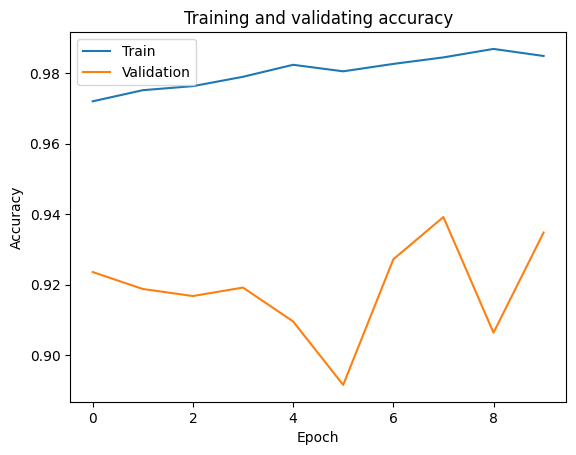

In [ ]:
plt.plot(history_mlp.history['accuracy'], label='Train')
plt.plot(history_mlp.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and validating accuracy')
plt.legend()
plt.show()

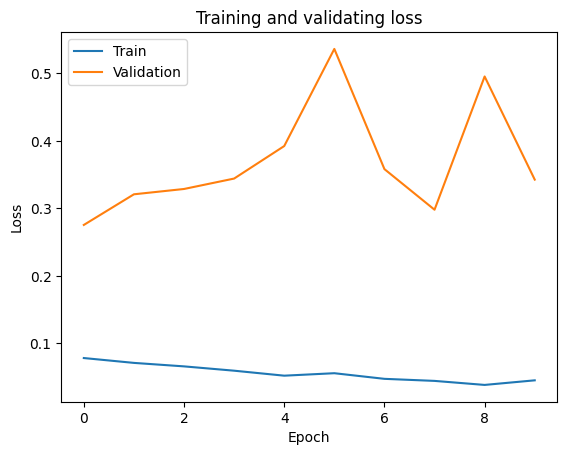

In [ ]:
plt.plot(history_mlp.history['loss'], label='Train')
plt.plot(history_mlp.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and validating loss')
plt.legend()
plt.show()

## 2 Regularization

Create an implementation for your regularized model here, e.g.

mlp2 = ...

In [10]:
# Your implementation for part 2 goes here
mlp2 = keras.Sequential(
    [
        layers.Input((2*imsize,imsize,3)),            # Tell Keras the shape of the input array (a 3-channel twice imsize by imsize image)
        layers.Reshape((2,imsize,imsize,3)),          # Turn the input into two 64x64 images
        layers.LayerNormalization(axis=[-1,-2,-3]),   # Normalize each image independently to mean=zero and sigma=one. YOUR MODEL WILL NOT WORK PROPERLY IF YOU DO NOT DO THIS
        layers.Flatten(),     # Unravel/flatten the input array
        layers.Dropout(rate= 0.98),
        layers.Dense(16,activation='relu'),           # A single hidden layer with 16 outputs
        layers.Dense(2,activation='softmax')          # A fully-connected layer with a softmax activation function to generate probabilities for the two classes (0bad and 1good)
    ]
)

In [11]:
# Configure the model
mlp2.compile(optimizer='adam',
           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #use SparseCategoricalCrossentropy because labels are integers. If the labels are one-hot representation, please use CategoricalCrossentropy loss.
           metrics=['accuracy'])

In [12]:
history_mlp2 = mlp2.fit(train_ds, epochs=20, batch_size=100, validation_data= validation_ds)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 920s 1s/step - accuracy: 0.5147 - loss: 2.6470 - val_accuracy: 0.8060 - val_loss: 0.5320
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.6214 - loss: 0.6415 - val_accuracy: 0.7552 - val_loss: 0.4777
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.6820 - loss: 0.5851 - val_accuracy: 0.7540 - val_loss: 0.4829
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.7021 - loss: 0.5648 - val_accuracy: 0.7352 - val_loss: 0.4862
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.7363 - loss: 0.5227 - val_accuracy: 0.8280 - val_loss: 0.3677
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.7697 - loss: 0.4863 - val_accuracy: 0.8204 - val_loss: 0.3711
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.7894 - loss: 0.4545 - val_accuracy: 0.8080 - val_loss: 0.3870
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.7982 - loss: 0.4418 - v

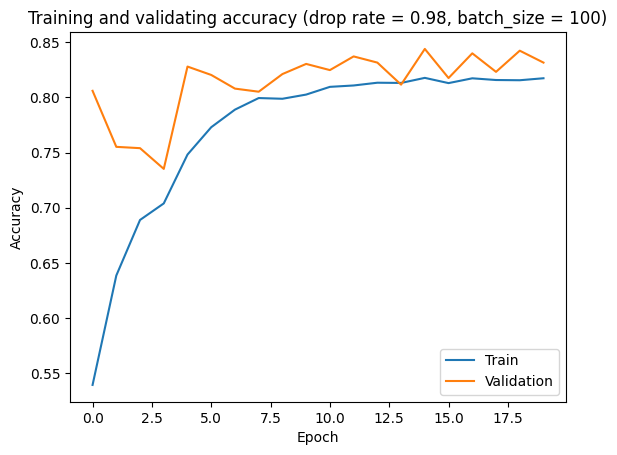

In [13]:
plt.plot(history_mlp2.history['accuracy'], label='Train')
plt.plot(history_mlp2.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and validating accuracy (drop rate = 0.98, batch_size = 100)')
plt.legend()
plt.show()

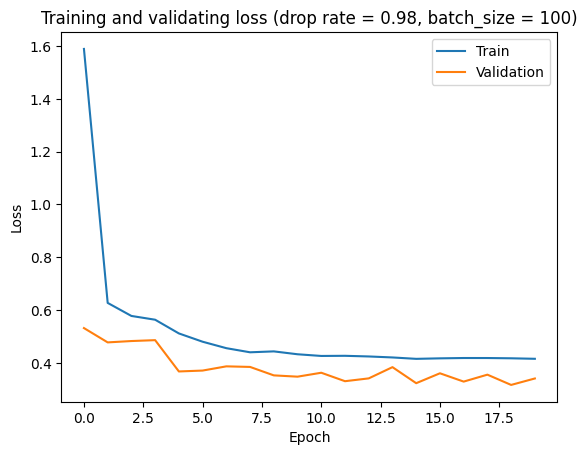

In [14]:
plt.plot(history_mlp2.history['loss'], label='Train')
plt.plot(history_mlp2.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and validating loss (drop rate = 0.98, batch_size = 100)')
plt.legend()
plt.show()

## 3 CNN

Create an implementation for your convolutional model here, e.g.

mlp3 = ...

In [27]:
# Your implementation for part 3 goes here
# Your implementation for part 2 goes here
mlp3 = keras.Sequential(
    [
        layers.Input((2*imsize,imsize,3)),            # Tell Keras the shape of the input array (a 3-channel twice imsize by imsize image)
        layers.Reshape((2,imsize,imsize,3)),          # Turn the input into two 64x64 images
        layers.LayerNormalization(axis=[-1,-2,-3]),   # Normalize each image independently to mean=zero and sigma=one. YOUR MODEL WILL NOT WORK PROPERLY IF YOU DO NOT DO THIS

        layers.TimeDistributed(layers.Conv2D(filters=128, kernel_size=(3, 3), strides = 3, activation='relu')),
        layers.TimeDistributed(layers.Conv2D(filters =256, kernel_size = (3,3), strides = 6, activation = 'relu')),

        layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2))),
        layers.TimeDistributed(layers.Flatten()),

        layers.Flatten(),     # Unravel/flatten the input array
        layers.Dropout(rate= 0.5),
        layers.Dense(16,activation='relu'),           # A single hidden layer with 16 outputs
        layers.Dense(2,activation='softmax')          # A fully-connected layer with a softmax activation function to generate probabilities for the two classes (0bad and 1good)
    ]
)

In [28]:
# Configure the model
mlp3.compile(optimizer='adam',
           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #use SparseCategoricalCrossentropy because labels are integers. If the labels are one-hot representation, please use CategoricalCrossentropy loss.
           metrics=['accuracy'])

In [29]:
history_mlp3 = mlp3.fit(train_ds, epochs=20, batch_size=100, validation_data= validation_ds)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 0.6339 - loss: 0.6159 - val_accuracy: 0.7760 - val_loss: 0.4639
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.8092 - loss: 0.4329 - val_accuracy: 0.8008 - val_loss: 0.4198
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.8358 - loss: 0.3889 - val_accuracy: 0.8556 - val_loss: 0.3427
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.8503 - loss: 0.3533 - val_accuracy: 0.8648 - val_loss: 0.3013
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.8731 - loss: 0.3119 - val_accuracy: 0.8944 - val_loss: 0.2528
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.8908 - loss: 0.2783 - val_accuracy: 0.8612 - val_loss: 0.3107
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.8950 - loss: 0.2674 - val_accuracy: 0.8984 - val_loss: 0.2401
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.8991 - loss: 0.2541 - 

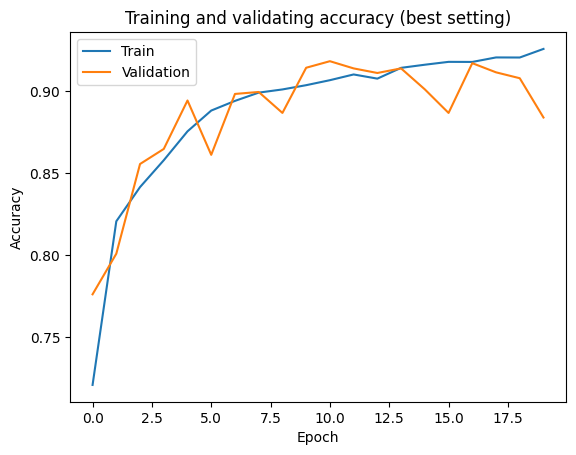

In [30]:
plt.plot(history_mlp3.history['accuracy'], label='Train')
plt.plot(history_mlp3.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and validating accuracy (best setting)')
plt.legend()
plt.show()

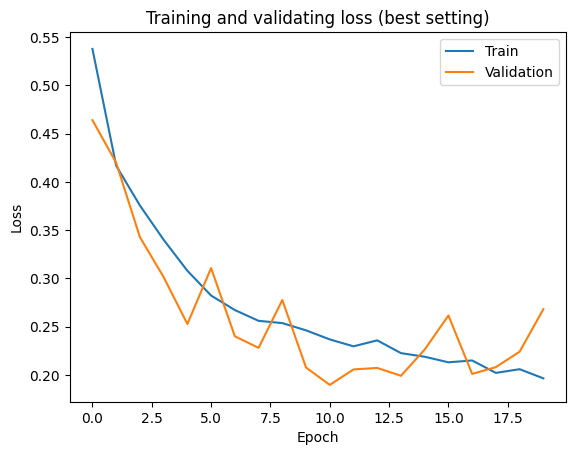

In [31]:
plt.plot(history_mlp3.history['loss'], label='Train')
plt.plot(history_mlp3.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and validating loss (best setting)')
plt.legend()
plt.show()